# topic2poem
End-to-End Poetry Generation from a list of topics using [T5: Text-To-Text Transfer Transformer](https://arxiv.org/abs/1910.10683)  
Author: [Harshit Varma](https://github.com/hrshtv)



## Install Dependencies

In [1]:
! pip install transformers==4.5.1
! pip install sentencepiece==0.1.94 # Version is important as T5's tokenizer has this version as a dependency 

     |████████████████████████████████| 2.1MB 28.1MB/s 
     |████████████████████████████████| 3.3MB 44.6MB/s 
     |████████████████████████████████| 901kB 43.8MB/s 
     |████████████████████████████████| 1.1MB 26.2MB/s 


## Connect to GDrive

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Start
To reset the notebook, run from this point

In [3]:
%reset -f

## Import Libraries

In [4]:
# General libraries
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts

# The general framework used
import torch
from torch.utils.data import Dataset, DataLoader

# T5 specific libraries
from transformers.optimization import Adafactor
from transformers import T5Tokenizer, T5ForConditionalGeneration

## Connecting to the GPU

In [5]:
torch.cuda.empty_cache()

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# See which GPU has been allotted 
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla T4


## Constants

In [7]:
PATH_DATA = "/content/gdrive/MyDrive/topic2poem/dataset.csv"
MODEL_NAME = "t5-base"

SEED = 1

# Specified in the number of tokens
INP_MAX_LEN = 128
OUT_MAX_LEN = 512

TRAIN_BATCH_SIZE = 4

N_EPOCHS = 10
LR = 1e-3

PREFIX = "poemify: " # The T5 prefix to append to the inputs
SENT_SEP = "|" # All newlines/multi-newlines are replaced by a single '|' as T5Tokenizer replaces "\n" by a space
TOPIC_SEP = ", " # Delimiter used for separating the topics in the input

In [8]:
# Set random seeds and make pytorch deterministic for reproducibility
# Reference: https://github.com/NVIDIA/framework-determinism/blob/master/pytorch.md
def setSeed():
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
setSeed()

## Helper Functions

In [9]:
def countParameters(model):
    """ Counts the total number of trainable and frozen/non-trainable parameters in the model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable, frozen

## Custom Dataset

In [10]:
class CustomDataset(Dataset):

    def __init__(self, df, tokenizer, inp_len, out_len):

        self.tokenizer = tokenizer
        self.df = df

        self.inp_len = inp_len # All input sequences would be padded to this length
        self.out_len = out_len # All output sequences would be padded to this length

        self.inp_txt = self.df.input
        self.out_txt = self.df.output


    def __len__(self):
        return len(self.out_txt)


    def __getitem__(self, index):

        inp_txt = str(self.inp_txt[index])
        out_txt = str(self.out_txt[index])

        # Encode the input and output texts
        source = self.tokenizer(
            [inp_txt],
            max_length = self.inp_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )

        target = self.tokenizer(
            [out_txt],
            max_length = self.out_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )

        # Input IDs and Masks
        source_ids = source["input_ids"].squeeze() # squeeze() to remove the additional dimension
        source_mask = source["attention_mask"].squeeze()
        target_ids = target["input_ids"].squeeze()
        target_mask = target["attention_mask"].squeeze()

        # Don't shift the inputs/outputs to GPU now, do it while loading the batches, and then shift the entire batch at once

        return {
            "source_ids"  : source_ids, 
            "source_mask" : source_mask, 
            "target_ids"  : target_ids,
            "target_mask" : target_mask
        }

## Data Handlers

In [11]:
def replaceSep(text, sep = SENT_SEP):
    """ Replaces all signle/multi-linebreaks by a single 'sep' everywhere, as T5Tokenizer just replaces '\n' by a blank space """
    corrupted_sentences = text.split("\n")
    sentences = [s.strip() for s in corrupted_sentences if len(s.strip()) > 1] # Only keep sentences of length > 1
    text = sep.join(sentences)
    return text

In [12]:
def loadDF(path, n_rows = None, prefix = PREFIX):
    """ Loads the CSV data, converts it to the specified format, and splits it into training and validation sets """

    # Read the CSV file
    df = pd.read_csv(PATH_DATA, encoding = "utf-8")

    # Drop the NaN rows (if any)
    df.dropna(inplace = True)

    # Choose the approproate columns containing the text input and the text output
    df = df[["Content", "Topics"]]

    # Rename the columns appropriately (dataset specific)
    df.rename(columns={"Content" : "output", "Topics" : "input"}, inplace=True)

    # Add a suitable prefix to the text input
    df["input"] = prefix + df["input"]

    # Truncate the dataset if specified
    if n_rows is not None:
        df = df.sample(n = n_rows, random_state = SEED)

    # Replace newlines in the poem
    df["output"] = df["output"].apply(replaceSep)

    # Train-Test Split
    df_train, df_val = tts(df, test_size = 5, random_state = SEED, shuffle = True)
    
    # Reset indices
    df_train.reset_index(drop = True, inplace = True)
    df_val.reset_index(drop = True, inplace = True)

    return df, df_train, df_val

In [13]:
def getDataLoaders(df_train, df_val, tokenizer):
    """ Returns the torch DataLoaders for the training and validation DFs """

    # Create Datasets
    ds_train = CustomDataset(df_train, tokenizer, INP_MAX_LEN, OUT_MAX_LEN)
    ds_val   = CustomDataset(df_val, tokenizer, INP_MAX_LEN, OUT_MAX_LEN)

    # Create Dataloaders
    dl_train = DataLoader(ds_train, batch_size = TRAIN_BATCH_SIZE, shuffle = True, num_workers = 0)
    dl_val   = DataLoader(ds_val, batch_size = TRAIN_BATCH_SIZE, shuffle = True, num_workers = 0)

    return dl_train, dl_val

## Train and Validate Functions

In [14]:
def train(tokenizer, model, loader, optimizer):
    """ A single epoch """

    model.train()

    loss_batches = []

    for iter, batch in enumerate(tqdm(loader)):

        # Reset gradients
        optimizer.zero_grad()

        source_ids  = batch["source_ids"].to(DEVICE)
        source_mask = batch["source_mask"].to(DEVICE)
        target_mask = batch["target_mask"].to(DEVICE)

        labels = batch["target_ids"]
        labels[labels[:, :] == tokenizer.pad_token_id] = -100
        labels = labels.to(DEVICE)

        outputs = model(
            input_ids = source_ids, 
            attention_mask = source_mask, 
            labels = labels,
            decoder_attention_mask = target_mask
        ) # Of type Seq2SeqLMOutput

        loss = outputs.loss
        
        loss_batches.append(loss.item())

        # Compute gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()

    # Average epoch loss:
    avg_epoch_loss = sum(loss_batches) / len(loss_batches)

    return avg_epoch_loss

## Generation

### Sampling

In [56]:
def genSample(topics, min_length, max_length, rep_penalty = 1, temp = 1, top_k = 50, top_p = 1.0, no_repeat_ngram_size = 3, num_return_sequences = 2, already_formatted = False):

    setSeed() # Required to ensure reproducibility

    if not already_formatted:
        input = PREFIX + TOPIC_SEP.join(topics)
    else:
        input = topics

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    model.eval()
    with torch.no_grad():
        output = model.generate(
            do_sample = True,
            input_ids = input_ids,
            min_length = min_length,
            max_length = max_length,
            top_p = top_p,
            top_k = top_k,
            temperature = temp,
            repetition_penalty = rep_penalty,
            no_repeat_ngram_size = no_repeat_ngram_size, # Don't repeat any n-grams of this size
            num_return_sequences = num_return_sequences
        )

    for i, generated_ids in enumerate(output):
        gen = tokenizer.decode(generated_ids, skip_special_tokens = True, clean_up_tokenization_spaces = True)
        sentences = gen.split(SENT_SEP)
        for s in sentences:
            print(s.strip())
        print("\n")

    return gen

### Beam Search

In [67]:
def genBeam(topics, min_length, max_length, rep_penalty = 1, n_beams = 2, no_repeat_ngram_size = 3, num_return_sequences = 2, already_formatted = False):

    setSeed() # Required to ensure reproducibility

    if not already_formatted:   
        input = PREFIX + TOPIC_SEP.join(topics)
    else:
        input = topics

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    model.eval()
    with torch.no_grad():
        output = model.generate(
            input_ids = input_ids,
            min_length = min_length,
            max_length = max_length,
            num_beams = n_beams,
            no_repeat_ngram_size = no_repeat_ngram_size, # Don't repeat any n-grams of this size
            repetition_penalty = rep_penalty,
            num_return_sequences = num_return_sequences
        )

    for generated_ids in output:
        gen = tokenizer.decode(generated_ids, skip_special_tokens = True, clean_up_tokenization_spaces = True)
        sentences = gen.split(SENT_SEP)
        for s in sentences:
            print(s.strip())
        print("\n")

    return gen

## Main

### Tokenizer

In [17]:
# T5's Tokenzier for encoding the text
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

In [18]:
example_text = "Far far away, behind the word mountains, far from the countries Vokalia and Consonantia, there live the blind texts.\nFar far away, behind the word mountains, far from the countries Vokalia and Consonantia, there live the blind texts"
example_input_ids = tokenizer(
    example_text,
    return_tensors = "pt"
).input_ids[0]
print(len(example_input_ids))
example_decoded = [tokenizer.decode(i, skip_special_tokens = True, clean_up_tokenization_spaces = True) for i in example_input_ids]
print(example_decoded)

56
['Far', 'far', 'away', ',', 'behind', 'the', 'word', 'mountains', ',', 'far', 'from', 'the', 'countries', 'Vo', 'k', 'alia', 'and', 'Cons', 'on', 'anti', 'a', ',', 'there', 'live', 'the', 'blind', 'texts', '.', 'Far', 'far', 'away', ',', 'behind', 'the', 'word', 'mountains', ',', 'far', 'from', 'the', 'countries', 'Vo', 'k', 'alia', 'and', 'Cons', 'on', 'anti', 'a', ',', 'there', 'live', 'the', 'blind', 'texts', '</s>']


### Loading the Data

In [19]:
df, df_train, df_val = loadDF(PATH_DATA, prefix = PREFIX)
print(len(df), len(df_train), len(df_val))

566 561 5


In [20]:
display(df)

,output,input
0,Deep on the convent-roof the snows|Are sparkli...,"poemify: heaven bursts, earthly spark, spirit ..."
1,Where Claribel low-lieth|The breezes pause and...,"poemify: thicket lone, wave outwelleth, throst..."
2,"You ask me, why, tho' ill at ease,|Within this...","poemify: sober-suited freedom, individual free..."
3,"Break, break, break,|On thy cold gray stones, ...","poemify: vanished hand, stately ships, sailor ..."
4,"Light, so low upon earth,|You send a flash to ...","poemify: kind, world, wooing, woods, wood, val..."
...,...,...
561,"A poet!|-He hath put his heart to school,|Nor ...","poemify: divine vitality, hand-must laugh, sta..."
562,"At the corner of Wood Street, when daylight ap...","poemify: wood street, small cottage, mountain ..."
563,Once did She hold the gorgeous east in fee;|An...,"poemify: gorgeous east, strength decay, maiden..."
564,Surprised by joy-impatient as the Wind|I turne...,"poemify: grievous loss, worst pang, face resto..."


In [21]:
dl_train, dl_val = getDataLoaders(df_train, df_val, tokenizer)
print(len(dl_train), len(dl_val))

141 2


In [22]:
def countTokens(text):
    input_ids = tokenizer(
        text,
        return_tensors = "pt"
    ).input_ids[0]
    return len(input_ids)

In [23]:
df["input_length"] = df["input"].apply(countTokens)
df["output_length"] = df["output"].apply(countTokens)

In [24]:
# Use this to select INP_MAX_LEN and OUT_MAX_LEN
print("Input Length (in tokens) Statistics")
print(df["input_length"].describe())
print()
print("Output Length (in tokens) Statistics")
print(df["output_length"].describe())

Input Length (in tokens) Statistics
count    566.000000
mean      39.888693
std       11.653097
min       13.000000
25%       32.000000
50%       38.000000
75%       47.000000
max       99.000000
Name: input_length, dtype: float64

Output Length (in tokens) Statistics
count    566.000000
mean     227.335689
std       91.572808
min       73.000000
25%      166.000000
50%      201.000000
75%      287.000000
max      497.000000
Name: output_length, dtype: float64


### Loading the Model

In [25]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)

In [26]:
p_train, p_frozen = countParameters(model)
print(f"The model has {p_train:,} trainable and {p_frozen:,} frozen parameters")

The model has 222,903,552 trainable and 0 frozen parameters


### Optimization

In [27]:
optimizer = Adafactor(
    params = model.parameters(),
    lr = LR,
    scale_parameter = False,
    relative_step = False
)

In [28]:
losses = []
for e in range(N_EPOCHS):
    print(f"Epoch {e+1}/{N_EPOCHS}")
    loss_epoch = train(tokenizer, model, dl_train, optimizer)
    losses.append(loss_epoch)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:562: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg_sq_row.mul_(beta2t).add_(1.0 - beta2t, update.mean(dim=-1))



Epoch 2/10



Epoch 3/10



Epoch 4/10



Epoch 5/10



Epoch 6/10



Epoch 7/10



Epoch 8/10



Epoch 9/10



Epoch 10/10


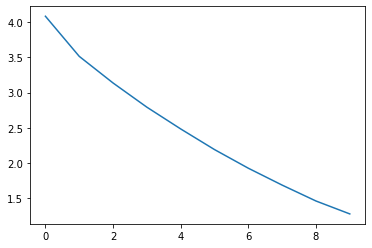

In [29]:
plt.plot(range(len(losses)), losses)
plt.show()

### Generation

In [78]:
val_list = df_val["input"].tolist()
for inp in val_list:
    print(f"Input: {inp}")
    genSample(
        topics = inp, 
        min_length = 0, 
        max_length = 500, 
        rep_penalty = 1.3, 
        temp = 0.9, 
        top_k = 50,
        top_p = 0.95,
        no_repeat_ngram_size = 3,
        num_return_sequences = 1,
        already_formatted = True
    )
    print("\n\n")

Input: poemify: heroic wealth, cheerful godliness, selfish men, lowliest duties, naked heavens, stagnant waters, english dower
The God of love, who made thee
Of himself a little selfish men, created
In that first meeting of heaven and earth;
And now these fallen trees in England dower.
These trees which lack vitality have not grown long,
And stagnant waters bring us pain:
This land of immortality does suffer but decay;
The manhood gives rise to bear,
The angels complain,
"But still we must strive for higher things."
Everyone will agree,
One answer shall speak English dower;
What will the youth take or should be?
Or is it that all human need be;
Who are they therefore to bear
For such heroic wealth so scarcely,
Nor ever with patience keep pace with stagnant water;
They shall make naked heavens again,
Red Roofs and roofs from ceilings!
If they were not themselves, then they would die





Input: poemify: watered shoot, thickset fruit, singing bird, silver grapes, silver fleurs-de-lys, pu

In [58]:
# Generate using Beam Search (usually very repetetive)
for inp in val_list:
    print(f"Input: {inp}")
    genBeam(
        topics = inp,
        min_length = 0,
        max_length = 500,
        rep_penalty = 1.5, 
        n_beams = 2,
        no_repeat_ngram_size = 3, 
        num_return_sequences = 1,
        already_formatted = True
    )
    print("\n\n")

Input: poemify: heroic wealth, cheerful godliness, selfish men, lowliest duties, naked heavens, stagnant waters, english dower
English dowers, proud men of high and lowliest duties,
Self-gathered in heroic wealth and cheerful godliness,
And naked heavens filled with stagnant waters;
The selfish men of England dower and lilies,
The cynical men of God, who make the most of themselves
In their own right hands. They know not well how to cast their money away;
But they know that they have not the highest duty to show
That they have the highest regard for highliest duties:
They understand not well the needful men,
Nor dare to cast his money away.
Then they shall be freed from their own blood,
Their own selfish men, their own waste of breath,
Men who make their living on earth,
Hath taken the highest part of mankind



Input: poemify: watered shoot, thickset fruit, singing bird, silver grapes, silver fleurs-de-lys, purple dyes, halcyon sea, vair, silk, rainbow, pomegranates, peacocks, paddles

In [59]:
sample_topics = ["dark woods", "river", "mountains", "valleys", "trees", "silent", "peaceful", "stars"]

In [76]:
gen = genSample(
    topics = sample_topics,
    min_length = 0, 
    max_length = 500, 
    rep_penalty = 1.3,
    temp = 0.9, 
    top_k = 50, 
    top_p = 0.9,
    no_repeat_ngram_size = 3,
    num_return_sequences = 3,
    already_formatted = False
)

O stars are silent in the dark woods,
On rivers and mountains;
All through them I come down peacefully.
I walk among the dead trees,
To sleep peaceful in the evening.
And I look up from my chair and lie upon her side
And gaze upon her sleeping.
Beside me she sits peaceful in her chair.
The river is silent in her position:
She stands alone in silence beside the star.
Outside me lieth quiet as a dove's nestle.
Nor will I rise again to see
The valleys of the river, that I love


What are the hills like, and where the rivers flow?
In the dark woods of the river, through the fields and valleys,
Where the trees grow silently.
The forest is green; but the leaves are still:
The oak is in the shade, and the red ash is white.
And all the trees are purple, and they are golden.
Only the stars are cast down, and their shadows disappear.
While the mountains are green, and peaceful,
The forests that we love are quiet,
When I watch the streams calm, and light
Through them stream, and make my dreams tr

In [72]:
gen = genBeam(
    topics = sample_topics,
    min_length = 0,
    max_length = 500,
    rep_penalty = 1.5, 
    n_beams = 2, 
    no_repeat_ngram_size = 3, 
    num_return_sequences = 2,
    already_formatted = False
)

I walk in the dark woods,
And look down upon the hills and valleys
Where the birds are found.
In the midst of the night I hear the river run
Across the mountains, and I hear them say:
"All the trees are beautiful,
All the flowers are white,
The leaves are green, the grass is green;
And the trees themselves are white.
My heart is in the trees,
But I am silent.
I watch the forests decline,
While the stars are dark and peaceful.
Let me take my baths as the river:
Letting me drink the same,
Silent and peaceful in the deep


I walk in the dark woods,
And look down upon the hills and valleys
Where the birds are found.
In the midst of the night I hear the river run
Across the mountains, and I hear them say:
"All the trees are beautiful,
All the flowers are white,
The leaves are green, the grass is green;
And the trees themselves are white.
My heart is in the trees,
But I am silent.
I watch the forests decline,
While the stars are dark and peaceful.
Let me take my baths as the river:
Letting m

### Save the finetuned model

In [35]:
torch.save(model, f"/content/gdrive/MyDrive/topic2poem/model_{N_EPOCHS}epochs.h5")